In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

# Comparing Performance of Different Models Used

### Naive Bayes Performance

![Naive Bayes Performance](../images/nb.png)

### Random Forest Performance

![Random Forest Performance](../images/rf.png)

It's interesting to note that the Naive Bayes (NB) and Random Forest (RF) scores look pretty similar to each other. For precision (the metric that we're looking to optimize), both NB and RF stay at the naive baseline (the total number of positively labeled samples) until they reach about .5 confidence, at which the precision score begins to rise in a somewhat logarithmic manner. The accuracy scores for each follow a similar pattern, except with the score diverging from the naive baseline at around .5 confidence level.

### Logistic Regression Performance

![Logistic Regression Performance](../images/lr.png)

For Logistic Regression (LR), the precision score appears to rise in a more linear fashion as the confidence threshold increases. Although the precision and accuracy scores stay at the naive baseline until about .25, they begin to diverge sooner than in the NB or RF models, suggesting that the model isn't just exploiting class imbalance. Accuracy also decreases in a more gradual, sigmoid-like fashion in the LR, compared to the harsher drop off with the NB and RF models. 

All of these charts show that there's a clear trade off between precision and accuracy scores, for this experiment.

### Let's explore some of the specific model scores in more detail.

In [3]:
nb_scores = pd.read_csv('../jsons/NB_scores.csv')
rf_scores = pd.read_csv('../jsons/RF_scores.csv')
lr_scores = pd.read_csv('../jsons/LR_scores.csv')

In [4]:
nb_scores.sort_values('thresholds',ascending=True,inplace=True)
rf_scores.sort_values('thresholds',ascending=True,inplace=True)
lr_scores.sort_values('thresholds',ascending=True,inplace=True)

In [5]:
all_scores = {'thresholds': nb_scores['thresholds'], 
        'nb_precision': nb_scores['precision_scores'],
              'rf_precision': rf_scores['precision_scores'],
              'lr_precision': lr_scores['precision_scores'],
              'nb_tp': nb_scores['true_positives'],
              'rf_tp': rf_scores['true_positives'],
              'lr_tp': lr_scores['true_positives'],
               'nb_fp': nb_scores['false_positives'],
              'rf_fp': rf_scores['false_positives'],
              'lr_fp': lr_scores['false_positives']
             }

In [6]:
precision_scores = pd.DataFrame(all_scores)

In [7]:
precision_scores['rf_delta'] = precision_scores['rf_tp'] - precision_scores['rf_fp']
precision_scores['lr_delta'] = precision_scores['lr_tp'] - precision_scores['lr_fp']
precision_scores['nb_delta'] = precision_scores['nb_tp'] - precision_scores['nb_fp']

In [8]:
precision_scores.head()

,thresholds,nb_precision,rf_precision,lr_precision,nb_tp,rf_tp,lr_tp,nb_fp,rf_fp,lr_fp,rf_delta,lr_delta,nb_delta
0,0.05,0.732356,0.732655,0.731570,15493,15492,15491,5662,5653,5684,9839,9807,9831
1,0.10,0.732435,0.733065,0.734289,15491,15486,15470,5659,5639,5598,9847,9872,9832
2,0.15,0.732510,0.733485,0.739239,15486,15478,15388,5655,5624,5428,9854,9960,9831
3,0.20,0.732977,0.734581,0.747653,15479,15460,15208,5639,5586,5133,9874,10075,9840
4,0.25,0.733694,0.735713,0.758103,15467,15436,14899,5614,5545,4754,9891,10145,9853


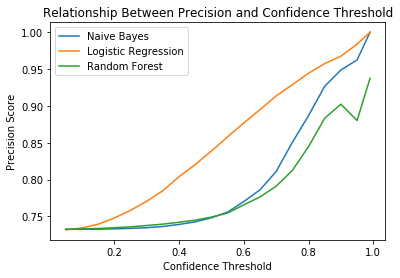

In [9]:
plt.plot('thresholds', 'nb_precision', data=all_scores, label='Naive Bayes')
plt.plot('thresholds', 'lr_precision', data=all_scores,label='Logistic Regression')
plt.plot('thresholds', 'rf_precision', data=all_scores,label='Random Forest')
plt.title('Relationship Between Precision and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision Score')

plt.legend()

Similar to what was observed above, the precision score for Logistic Regression appears to rise in a somewhat linear fashion, as the confidence threshold increases. NB and RF stay very close to the naive baseline until they reach about .5 confidence threshold, and then go up rapidly. It's also interesting to note that the RF does not reach 1.0 precision, even when the confidence threshold is 1.0.

It is also important to note that the LR model has a consistently higher Precision Score than the other two models, throughout all confidence threshold levels. Since this is the classification metric that we will be optimizing for, this is a major point in the LR's favor.

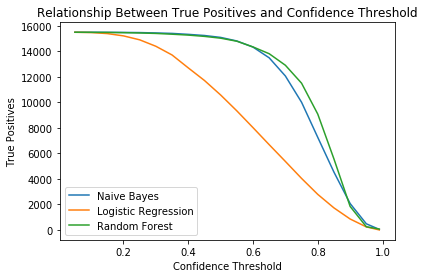

In [10]:
plt.plot('thresholds', 'nb_tp', data=all_scores, label='Naive Bayes')
plt.plot('thresholds', 'lr_tp', data=all_scores,label='Logistic Regression')
plt.plot('thresholds', 'rf_tp', data=all_scores,label='Random Forest')
plt.title('Relationship Between True Positives and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('True Positives')

plt.legend()

The logisitic regression has fewer True Positives at nearly all threshold levels, and the true positives decrease in a somewhat sigmoid shape. NB and Random Forest look very similar, with True Positives dropping rapidly around .5. Naive Bayes appears to have fewer True Positives around the .65 to .8 range.

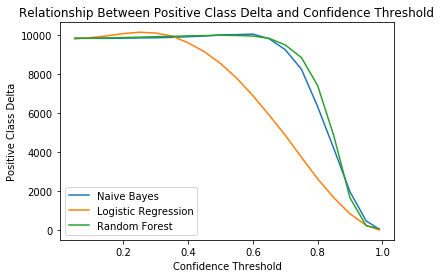

In [11]:
plt.plot('thresholds', 'nb_delta', data=precision_scores, label='Naive Bayes')
plt.plot('thresholds', 'lr_delta', data=precision_scores,label='Logistic Regression')
plt.plot('thresholds', 'rf_delta', data=precision_scores,label='Random Forest')
plt.title('Relationship Between Positive Class Delta and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Positive Class Delta')

plt.legend()

The chart shows the difference in True Positives and False Positives per model, as the positive class confidence threshold increases. This is beneficial in cases where it is important to limit False Positives.

As the chart shows, although the LR model does not generate as many True Positives as the other two models, it is much better at limiting the False Positives (which makes sense since it has a consistently higher precision score throughout threshold levels). It is, however, interesting to note that the LR actually has a higher delta than either NB or RF, likely because the latter two are taking advantage of class imbalance, and frequently choosing the positive class.

# Probability Comparison

Now let's compare how the models assessed specific posts, in terms of class probability.

In [12]:
orig_text = pd.read_csv('../jsons/text_labels.csv')

In [13]:
orig_text.head()

,label,text
0,2,Be Fun Fancy Free sort comment new thread Fun ...
1,8,As far I'm concerned Guillermo del Toro constr...
2,10,I writing essay I can't find word something lo...
3,14,Video Form Ah scary movie There something make...
4,15,Please use discus week's latest release We're ...


In [14]:
nb_probas = pd.read_csv('../jsons/NB_probas.csv')
rf_probas = pd.read_csv('../jsons/RF_probas.csv')
lr_probas = pd.read_csv('../jsons/LR_probas.csv')

In [15]:
merged_probas = nb_probas.merge(rf_probas,on=['label','target']).merge(lr_probas,on=['label','target'])

In [16]:
merged_probas['text'] = orig_text['text']

In [17]:
merged_probas.head()

,label,NB_0,NB_1,target,RF_0,RF_1,LR_0,LR_1,text
0,2,0.000004,0.999996,1.0,0.000000,1.000000,0.061948,0.938052,Be Fun Fancy Free sort comment new thread Fun ...
1,8,0.108307,0.891693,1.0,0.136667,0.863333,0.067615,0.932385,As far I'm concerned Guillermo del Toro constr...
2,10,0.133968,0.866032,1.0,0.124167,0.875833,0.202263,0.797737,I writing essay I can't find word something lo...
3,14,0.631982,0.368018,1.0,0.252500,0.747500,0.664586,0.335414,Video Form Ah scary movie There something make...
4,15,0.256183,0.743817,1.0,0.005000,0.995000,0.476536,0.523464,Please use discus week's latest release We're ...


Even after just looking at the head, it is clear that there are some major differences in terms of the different model's confidences toward certain posts.

At first glance, it seems like the RF model is much more likely to have close to a 100% confidence in its classification than the LR or Naive Bayes models. This might not necessarily be a good thing if it is misclassifying, however, and there could be a benefit to Logistic Regression displaying a ~50% confidence rating if it is unsure, especially in terms of helping to tune the model.

Let's look at posts where the NB model had more than 50% confidence in the positive class, but where LR had less than 50% confidence.

In [18]:
len(merged_probas.loc[(merged_probas['LR_1'] < .5) & (merged_probas['NB_1'] > .5)].sort_values('LR_1',ascending=False))

7570

In [19]:
7570 / len(merged_probas)

0.3571597074781788

Seems like it occurs fairly often (35.7%). What about instances where the LR has more than 50% confidence, but NB has less than 50%?

In [20]:
len(merged_probas.loc[(merged_probas['NB_1'] < .5) & (merged_probas['LR_1'] > .5)].sort_values('LR_1',ascending=False))

13

Interestingly enough, this occurs very infrequently. 

In [74]:
naive_positive = merged_probas.loc[(merged_probas['LR_1'] < .5) & (merged_probas['NB_1'] > .5)].sort_values('LR_1',ascending=False)

In [81]:
naive_positive[['text', 'target', 'LR_1', 'NB_1', 'RF_1']].head(10)

,text,target,LR_1,NB_1,RF_1
7177,This comment You think ok,1.0,0.499988,0.762035,0.825825
19506,Yeah I get interesting decision replaced chara...,0.0,0.499962,0.716319,0.710167
16446,I disagree point Annihilation focused bedazzli...,0.0,0.499949,0.785875,0.822179
7837,Yeah watching second time great could notice m...,1.0,0.499943,0.727455,0.725000
17067,True put effort know I want I liked able walk ...,0.0,0.499933,0.718660,0.585000
20376,The action PG could used R rated violence I gu...,0.0,0.499910,0.722934,0.672083
2248,The whole point supposed empathize girl come r...,1.0,0.499907,0.811126,0.690000
20179,It sound like accord really There people inter...,0.0,0.499887,0.845097,0.820000
17486,The remaining character know however For know ...,0.0,0.499871,0.670180,0.825000
11803,Mandy mentioned live Crystal Lake nod Friday t...,1.0,0.499863,0.506745,0.860000


It seems like the RF and NB models are much more likely to give aggressive probabilities than LR, with mixed results. In cases where the text is less-than-conclusive, it is probably beneficial to have the model deliver a predicted probability of ~50%, rather than guessing incorrectly.

In [19]:
len(merged_probas.loc[(merged_probas['LR_1'] < .51) & (merged_probas['LR_1'] > .49)])

664

On 664 occasions out of 21195 (3% of the time), the LR classifier has a predicted probability from between .51 to .49.

In [20]:
len(merged_probas.loc[(merged_probas['NB_1'] < .51) & (merged_probas['NB_1'] > .49)])

190

In [21]:
len(merged_probas.loc[(merged_probas['RF_1'] < .51) & (merged_probas['RF_1'] > .49)])

135

It appears that the NB and RF classifiers give an "unsure" predicted probability at a much less frequent rate than the LR, which could be helpful if they are classifying correctly.

In [27]:
len(merged_probas.loc[(merged_probas['LR_1'] < .6) & (merged_probas['LR_1'] > .4)])

6654

In [25]:
len(merged_probas.loc[(merged_probas['NB_1'] < .6) & (merged_probas['NB_1'] > .4)])

2132

In [26]:
len(merged_probas.loc[(merged_probas['RF_1'] < .6) & (merged_probas['RF_1'] > .4)])

1813

In [24]:
6654 / len(merged_probas)

0.3139419674451522

The LR's approach to ambiguity is even more clear when looking at the probability, as it has a positive class probability of between .4 and .6 for about 30% of posts.

As we are looking to minimize False Positives, I think that this is a sensible approach, and that a LR is the best choice for this context. I also think that the top coefficients for the LR are more sensible and interpretable, when compared to the domain that it is modeling.

In the future, I think it could be beneficial to take a look at some of the ambiguously labeled posts as a form of model tuning, and possibly inspiration about additional stop words to add.